In [2]:
import torch
import numpy as np
from torch import nn, optim

import matplotlib.pyplot as plt

%matplotlib inline

# Generating some synthetic data from known nonlinear function

float64
(100, 100)


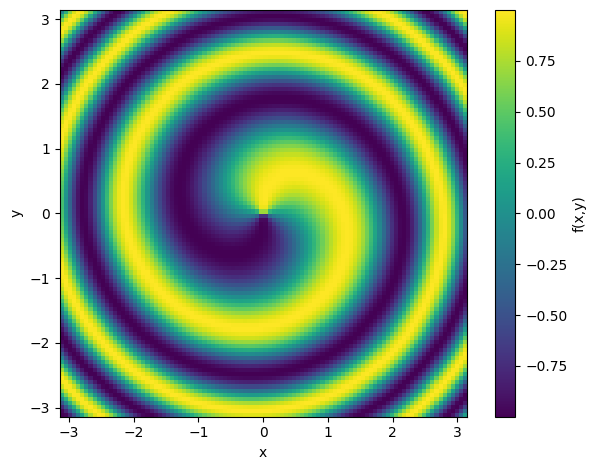

In [5]:
def nl_func(x,y):
    return np.sin(x**2 + y**2 + np.arctan2(y,x))

x = np.pi*np.linspace(-1,1,100)
y = np.pi*np.linspace(-1,1,100)
x, y = np.meshgrid(x,y)

f = nl_func(x,y)

plt.imshow(f, origin='lower', extent = [x.min(), x.max(), y.min(), y.max()], aspect=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='f(x,y)')
plt.tight_layout()

print(f.dtype)
print(f.shape)

In [3]:
# converting data into torch arrays
X = torch.from_numpy(x.flatten()).float().reshape(-1,1)
Y = torch.from_numpy(y.flatten()).float().reshape(-1,1)
F = torch.from_numpy(f.flatten()).float().reshape(-1,1)

In [45]:
class MLP(nn.Module): # MultiLayerPerceptron
    def __init__(self):
        super(MLP, self).__init__()
        # layers
        self.il  = nn.Linear(2,20) # takes 2 inputs and maps to a layer with 50 nodes
        self.hl1 = nn.Linear(20,20) # takes 50 inputs and maps to another layer with 50 nodes
        self.hl2 = nn.Linear(20,20) # ... 
        self.hl3 = nn.Linear(20,20) # ...
        self.ol  = nn.Linear(20,1) # takes 50 inputs and maps to the final layer with 1 node (this network outputs a scalar value)
        # activation functions
        self.tn  = nn.Tanh()
        self.elu  = nn.ELU()

    def forward(self, x, y):
        # setting up the forward model
        u = torch.cat((x, y), 1)
        u = self.il(u)
        u = self.elu(u)
        u = self.hl1(u)
        u = self.elu(u)
        u = self.hl2(u)
        u = self.elu(u)
        u = self.hl3(u)
        u = self.elu(u)
        u = self.ol(u)
        return u

In [77]:
NN_model = MLP()

loss_evol = []
optimizer = optim.Adam(NN_model.parameters(), lr=0.001) # Adam is a better optimizer for neural networks than simple gradient descent. It uses the same ideas as gradient descent but, this is more efficient.
# optimizer = optim.SGD(NN_model.parameters(), lr=0.0001)


epocs = 1000

n_batches = 10

In [78]:

for epoc in range(1, epocs+1):
    n_points = X.shape[0]
    idxs_shuffle = np.random.choice(n_points, size = n_points, replace = False)
    for i in range(n_batches):
        # batch of inputs
        X_batch = X[idxs_shuffle[i::n_batches],:]
        Y_batch = Y[idxs_shuffle[i::n_batches],:]
        # batch of target outputs
        F_batch = F[idxs_shuffle[i::n_batches],:]
        
        # batch of predicted outputs
        output_batch = NN_model(X_batch, Y_batch)

        # compute loss between target values and predicted values
        loss = torch.mean(torch.square(output_batch-F_batch))
        # keep track of loss function evolution to check if we are converging
        loss_evol.append(loss.detach().numpy())
        
        # optimize -> 3 steps: 
        # zero the gradients calculated in the previous iteration
        optimizer.zero_grad()
        # compute the new gradients using backward propagation
        loss.backward()
        # update the weights of the NN based on the computed gradients
        optimizer.step()

    if epoc % 100 == 0:
        print('epoc = ', epoc)
        print('loss = ', float(loss))

epoc =  100
loss =  0.45639148354530334
epoc =  200
loss =  0.23875130712985992
epoc =  300
loss =  0.11373542249202728
epoc =  400
loss =  0.04906045272946358
epoc =  500
loss =  0.031876400113105774
epoc =  600
loss =  0.021934419870376587
epoc =  700
loss =  0.014301964081823826
epoc =  800
loss =  0.012107961811125278
epoc =  900
loss =  0.011600607074797153
epoc =  1000
loss =  0.008314438164234161


Text(0.5, 0, 'grad. descent iter.')

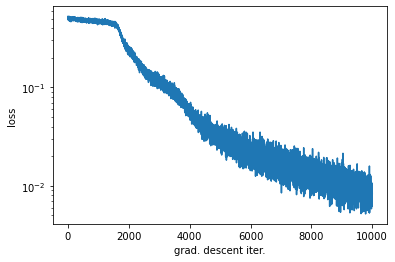

In [79]:
# Here we see the loss function decreasing with the number of iterations indicating that the NN model is "learning" the data
plt.semilogy(loss_evol)
plt.ylabel('loss')
plt.xlabel('grad. descent iter.')

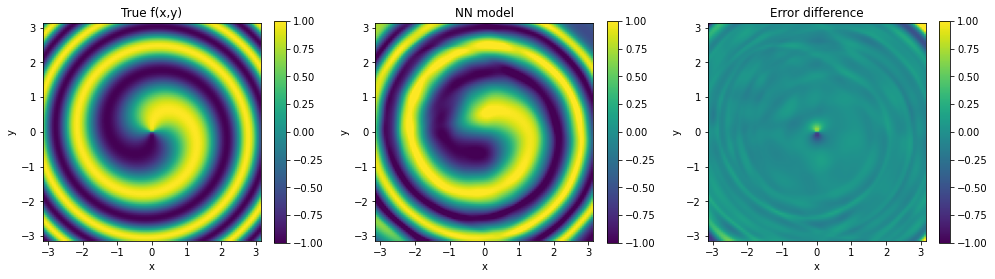

In [86]:
nx = x.shape[0]
ny = x.shape[1]
F_hat = (NN_model(X, Y)).T.reshape(nx,ny).detach().numpy()

plt.figure(figsize=(14,3.75))
plt.subplot(1,3,1)
plt.title('True f(x,y)')
plt.imshow(f, origin='lower', vmax = 1, vmin = -1, extent = [x.min(), x.max(), y.min(), y.max()], aspect=1)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,3,2)
plt.title('NN model')
plt.imshow(F_hat, origin='lower', vmax = 1, vmin = -1, extent = [x.min(), x.max(), y.min(), y.max()], aspect=1)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,3,3)
plt.title('Error difference')
plt.imshow(f-F_hat, origin='lower', vmax = 1, vmin = -1, extent = [x.min(), x.max(), y.min(), y.max()], aspect=1)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')


plt.tight_layout()
